In [1]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn.parallel import DataParallel

In [2]:
data = pd.read_csv("/bbc_data.csv")

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
sentences = data['data'].values
labels = data['labels'].values

In [7]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
model = DataParallel(model)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def evaluate_model(model, test_dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in test_dataloader:
            inputs, labels = batch
            outputs = model(inputs)
            _, preds = torch.max(outputs.logits, 1)
            all_labels.extend(labels.tolist())
            all_preds.extend(preds.tolist())
    accuracy = accuracy_score(all_labels, all_preds)
    print("Test Accuracy:", accuracy)
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['class_0', 'class_1', 'class_2', 'class_3', 'class_4'], yticklabels=['class_0', 'class_1', 'class_2', 'class_3', 'class_4'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [9]:
def save_model(model, path):
    model.save_pretrained(path)

In [10]:
def train_model(model, train_dataloader, optimizer, criterion, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss = total_loss / len(train_dataloader)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()

In [11]:
def predict_text(model, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    _, preds = torch.max(outputs.logits, 1)
    return preds.item()

In [12]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

In [11]:
print(train_sentences[:1])
print(test_sentences[:1])

['Blair hails Turkey-EU talks deal  Tony Blair has hailed a deal bringing Turkey a step closer to EU membership as important for the worlds future "peace and prosperity".  Mr Blair has been a leading advocate of Turkish membership despite controversy surrounding the idea. Leaving a Brussels summit Mr Blair said "the fact Turkey is a Muslim country does not mean it should be barred". The deal to open formal talks with Ankara came despite an EU demand for Turkey to recognise Cyprus. It was agreed the issue can be tackled at a later date but Turkish premier Recep Erdogan had to accept negotiations did not guarantee his country full EU membership.  If it joins, Turkey may have to accept restrictions to limit migration by its citizens. Mr Blair said having Turkey in the EU was of "importance to the future peace and prosperity of my country, Britain, and the wider world".  "We are stating a fundamental principle that the fact Turkey is a Muslim country does not mean it should be barred from 

In [13]:
train_encodings = tokenizer(list(train_sentences), truncation=True, padding=True, return_attention_mask=True)
test_encodings = tokenizer(list(test_sentences), truncation=True, padding=True, return_attention_mask=True)

In [14]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [15]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_labels_encoded))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']), torch.tensor(test_labels_encoded))

In [16]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2)

In [21]:
torch.cuda.empty_cache()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/5, Loss: 0.3737196395487598
Epoch 2/5, Loss: 0.07544842253313556
Epoch 3/5, Loss: 0.02581105445998229
Epoch 4/5, Loss: 0.010419426994853433
Epoch 5/5, Loss: 0.017550620197428368


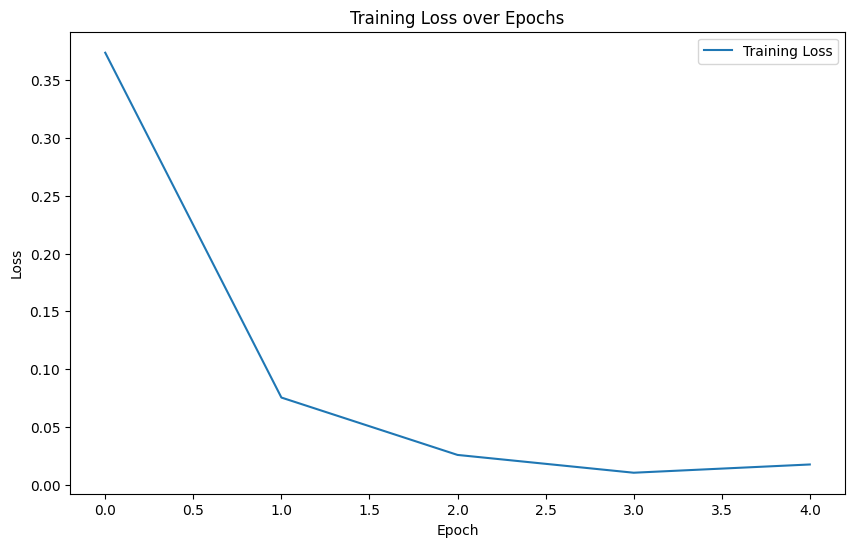

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
train_model(model, train_dataloader, optimizer, criterion)

In [19]:
model = model.module
save_model(model, "/trained_model")

Test Accuracy: 0.9797752808988764


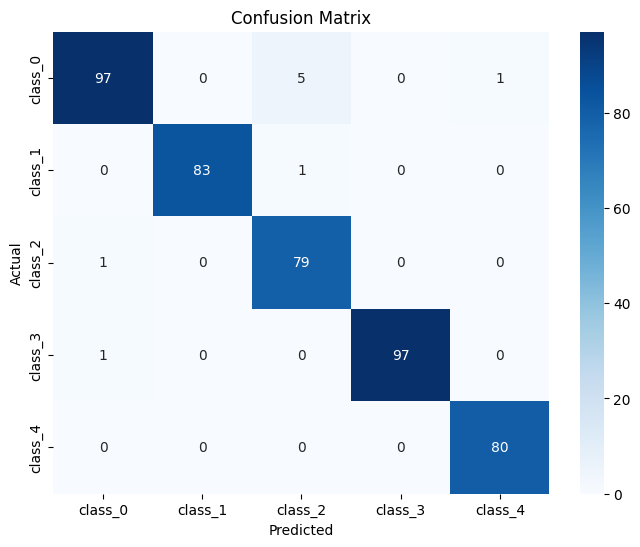

In [21]:
model.to('cpu')
evaluate_model(model, test_dataloader)